In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set(style="whitegrid")

from pandas.tools.plotting import autocorrelation_plot
import seaborn as sns
% matplotlib inline
cm_light = mpl.colors.ListedColormap(['#77E0A0', '#FF8080', '#A0A0FF'])
cm_dark = mpl.colors.ListedColormap(['g', 'r', 'b'])


In [2]:
import xgboost as xgb
HR_train = pd.read_csv("data/pfm_train.csv")
train_size = HR_train.shape[0]
HR_test = pd.read_csv('data/pfm_test.csv')
HR_test['Attrition']= None
obsAttr= HR_train.Attrition.value_counts()

print("train set有 %d 行, %d 列, 正负例样本比例：1: %f"  % (*HR_train.shape,obsAttr[0]/obsAttr[1]))
print("test set有 %d 行, %d 列"  % HR_test.shape)

train set有 1100 行, 31 列, 正负例样本比例：1: 5.179775
test set有 350 行, 31 列


In [3]:
HR_emp_att = pd.concat([HR_train,HR_test],axis=0)
HR_emp_att = HR_emp_att.reset_index(drop=True)
none_attr_cnt = HR_emp_att.Attrition.isnull().sum()
print('samples# in test dataset: %d'%none_attr_cnt)

samples# in test dataset: 350


In [4]:
dim = HR_emp_att.shape

print("数据集有 %d 行, %d 列"  % dim)

数据集有 1450 行, 31 列


## Check numeric data distribution are same between train/test dataset 
if any feature does not follow norm, create distritized feature

In [5]:
from scipy.stats import kstest, ks_2samp
ls_col= HR_test.select_dtypes(np.number).columns

ls_pvalue = []
ls_ksvalue = []
ls_kstest = []
for col in ls_col:
    ksval,pvalue = ks_2samp(HR_train[col],HR_test[col])
    ls_ksvalue.append(ksval)
    ls_pvalue.append(pvalue)
    kst = kstest(np.vstack([HR_train[col].values.reshape(-1,1),HR_test[col].values.reshape(-1,1)]),'norm')

    ls_kstest.append(kst.statistic)

df_ks2samp = pd.DataFrame({'col':ls_col,'pvalue':ls_pvalue,'ksvalue':ls_ksvalue,'kstest':ls_kstest}).sort_values('pvalue')
df_ks2samp.head()


,col,kstest,ksvalue,pvalue
1,DistanceFromHome,1.000000,0.068701,0.156783
20,YearsSinceLastPromotion,1.000000,0.047922,0.565514
17,WorkLifeBalance,0.999968,0.046364,0.608083
12,RelationshipSatisfaction,0.999968,0.045714,0.625997
16,TrainingTimesLastYear,1.000000,0.040260,0.774586


above table show that DistanceFromHome and YearsSinceLastPromotion are not same prob distribution across train and test set, so that discritize is necessary 

----

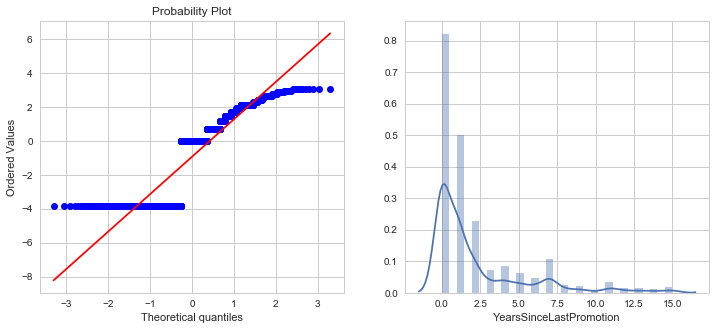

In [6]:
#  test transform feature to norm using box-cox
col='YearsSinceLastPromotion'
vals = np.vstack(HR_emp_att[col].values.reshape(-1,1))
# pd.qcut(pd.Series(vals.reshape(-1)),4,duplicates='drop')

from scipy import stats
fig=plt.figure(figsize=(12,5))                                                                                                                            
ax2 =plt.subplot(121)

stats.probplot(stats.boxcox(vals.ravel()+0.01)[0],dist=stats.norm,plot=ax2)
stats.boxcox(vals.ravel()+1)
plt.subplot(122)
sns.distplot(HR_emp_att[col]);


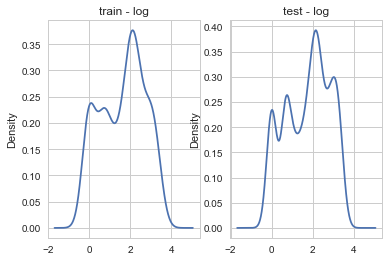

In [7]:
plt.subplot(1,2,1)
HR_test.DistanceFromHome.apply('log').plot(kind='kde',title='train - log')
plt.subplot(1,2,2)
HR_emp_att.DistanceFromHome.apply('log').plot(kind='kde',title='test - log');

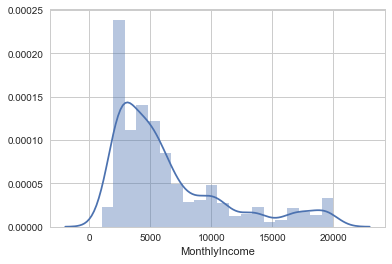

In [8]:
sns.distplot(HR_emp_att.MonthlyIncome);

## plot clustering group of option level
> verify if StockOptionLevel has strong correlate with Income

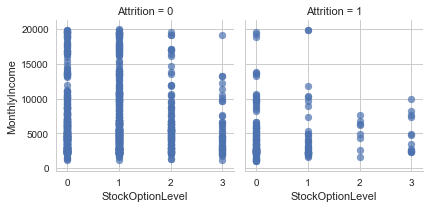

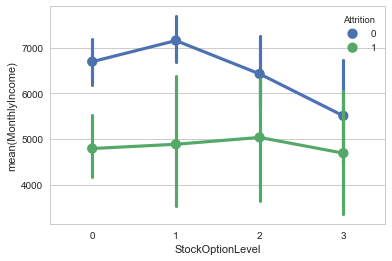

In [9]:
g = sns.FacetGrid(HR_emp_att, col="Attrition")
g.map(plt.scatter, "StockOptionLevel", "MonthlyIncome", alpha=.7)
g.add_legend();
plt.figure()
sns.pointplot(x ='StockOptionLevel' ,y ='MonthlyIncome', data=HR_emp_att, hue='Attrition' );



## 删除没有实际含义的特征

- 删除常数列
- 删除员工编号
- 根据员工编号按部门和岗位分组计算百分比（5段）

In [10]:
feature_unique_cnt = HR_emp_att.apply(lambda c : len(c.unique()))
print('特征值相同的列：')
features_has_same_val = feature_unique_cnt[feature_unique_cnt==1]
print(features_has_same_val.index)


特征值相同的列：
Index(['Over18', 'StandardHours'], dtype='object')


In [11]:
# 删除Over18/ StandardHours
if features_has_same_val.index.values[0] in HR_emp_att.columns:
    HR_emp_att = HR_emp_att.drop(features_has_same_val.index, axis=1)
dim = HR_emp_att.shape
print("删除重复值列后，数据集有 %d 行, %d 列"  % dim)

删除重复值列后，数据集有 1450 行, 29 列


In [12]:
# 由于缺少员工编号的上下文背景，删除EmployeeNumber
if 'EmployeeNumber' in HR_emp_att.columns:
    HR_emp_att['EmpNumQauntile_In_DeptRole']= HR_emp_att.groupby(['Department','JobLevel'])['EmployeeNumber'].transform(lambda g: pd.qcut(g.rank(),5,labels=range(5)))
    HR_emp_att = HR_emp_att.drop('EmployeeNumber', axis=1)
dim = HR_emp_att.shape
print("删除EmployeeNumber列后，数据集有 %d 行, %d 列"  % dim)

删除EmployeeNumber列后，数据集有 1450 行, 29 列


## 类别变量、数值变量类型重定义
根据字段描述，下列字段需要转换成类别特征：
- Education
- EnvironmentSatisfaction
- JobInvolvement
- JobLevel
- JobSatisfaction
- PerformanceRating
- RelationshipSatisfaction
- StockOptionLevel
- WorkLifeBalance
- Attrition

In [13]:
HR_emp_att.Education = pd.Categorical(HR_emp_att.Education)
HR_emp_att.JobLevel = pd.Categorical(HR_emp_att.JobLevel)
HR_emp_att.StockOptionLevel = pd.Categorical(HR_emp_att.StockOptionLevel)
HR_emp_att.Attrition = pd.Categorical(HR_emp_att.Attrition)


for obj_var in HR_emp_att.select_dtypes(['object']).columns.values:
    HR_emp_att[obj_var] = pd.Categorical(HR_emp_att[obj_var])

## test linearcolnity with MonthlyIncome


In [1]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

X_train = HR_emp_att.drop(['Attrition','MonthlyIncome'], axis=1).copy()
y_train = HR_emp_att.MonthlyIncome


def factorize_dataframe(data,cols):
    for col in cols:
        if data[col].dropna().drop_duplicates().shape[0]>2:
            df_dummy = pd.get_dummies(data[col],prefix=col) # factorize return 2 elements array, values and category index
            data = pd.concat([data,df_dummy],axis=1)
            data=data.drop(col,axis=1)
        else:
            data[col] = pd.factorize(data[col])[0]
    return data
     
     
cat_vars = X_train.dtypes.index[X_train.dtypes=='category']
X_train = factorize_dataframe(X_train, cat_vars)
# build ridge model
model_ridge = Ridge(normalize=True,random_state=44,fit_intercept=True,alpha=.3)
model_ridge.fit(X_train,y_train)
df_eval = pd.DataFrame({'Feature':X_train.columns[(model_ridge.coef_>.01)],'Support':model_ridge.coef_[model_ridge.coef_>.01]},columns=['Feature','Support'])
print(df_eval.sort_values('Support',ascending=False))
print(model_ridge.intercept_)
r_sqr = model_ridge.score(X_train,y_train)
print('r2 square:%f'%r_sqr)

ImportError: cannot import name 'add_newdocs'

## test feature importance

In [15]:
"""
test feature importance
"""
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, classification_report

X_train = HR_emp_att[HR_emp_att.Attrition.isnull()==False].drop(['Attrition'], axis=1).copy()
y_train = HR_emp_att[HR_emp_att.Attrition.isnull()==False].Attrition

   
cat_vars = X_train.dtypes.index[X_train.dtypes=='category']
X_train = factorize_dataframe(X_train, cat_vars)
# build ridge model
model_rfc = RandomForestClassifier(random_state=40, class_weight='balanced',warm_start=True)
model_rfc.fit(X_train,y_train)
df_eval = pd.DataFrame({'Feature':X_train.columns[(model_rfc.feature_importances_>.01)],'Support':model_rfc.feature_importances_[model_rfc.feature_importances_>.01]},columns=['Feature','Support'])
print(df_eval.sort_values('Support',ascending=False))
y_hat = model_rfc.predict(X_train)
clf_reprot = classification_report(y_train.ravel(),y_hat.ravel())
print(clf_reprot)

                         Feature   Support
0                            Age  0.068378
8                       OverTime  0.060641
6                  MonthlyIncome  0.058852
11             TotalWorkingYears  0.051444
1               DistanceFromHome  0.050102
7             NumCompaniesWorked  0.047004
14                YearsAtCompany  0.042542
9              PercentSalaryHike  0.035934
21            StockOptionLevel_0  0.034144
17          YearsWithCurrManager  0.033113
2        EnvironmentSatisfaction  0.030070
5                JobSatisfaction  0.029610
15            YearsInCurrentRole  0.028522
4                 JobInvolvement  0.024859
22            StockOptionLevel_1  0.024362
20          MaritalStatus_Single  0.022815
10      RelationshipSatisfaction  0.021560
18                    JobLevel_1  0.019561
16       YearsSinceLastPromotion  0.018642
12         TrainingTimesLastYear  0.018569
13               WorkLifeBalance  0.017184
3                         Gender  0.011915
23  EmpNumQ

## plot distribution

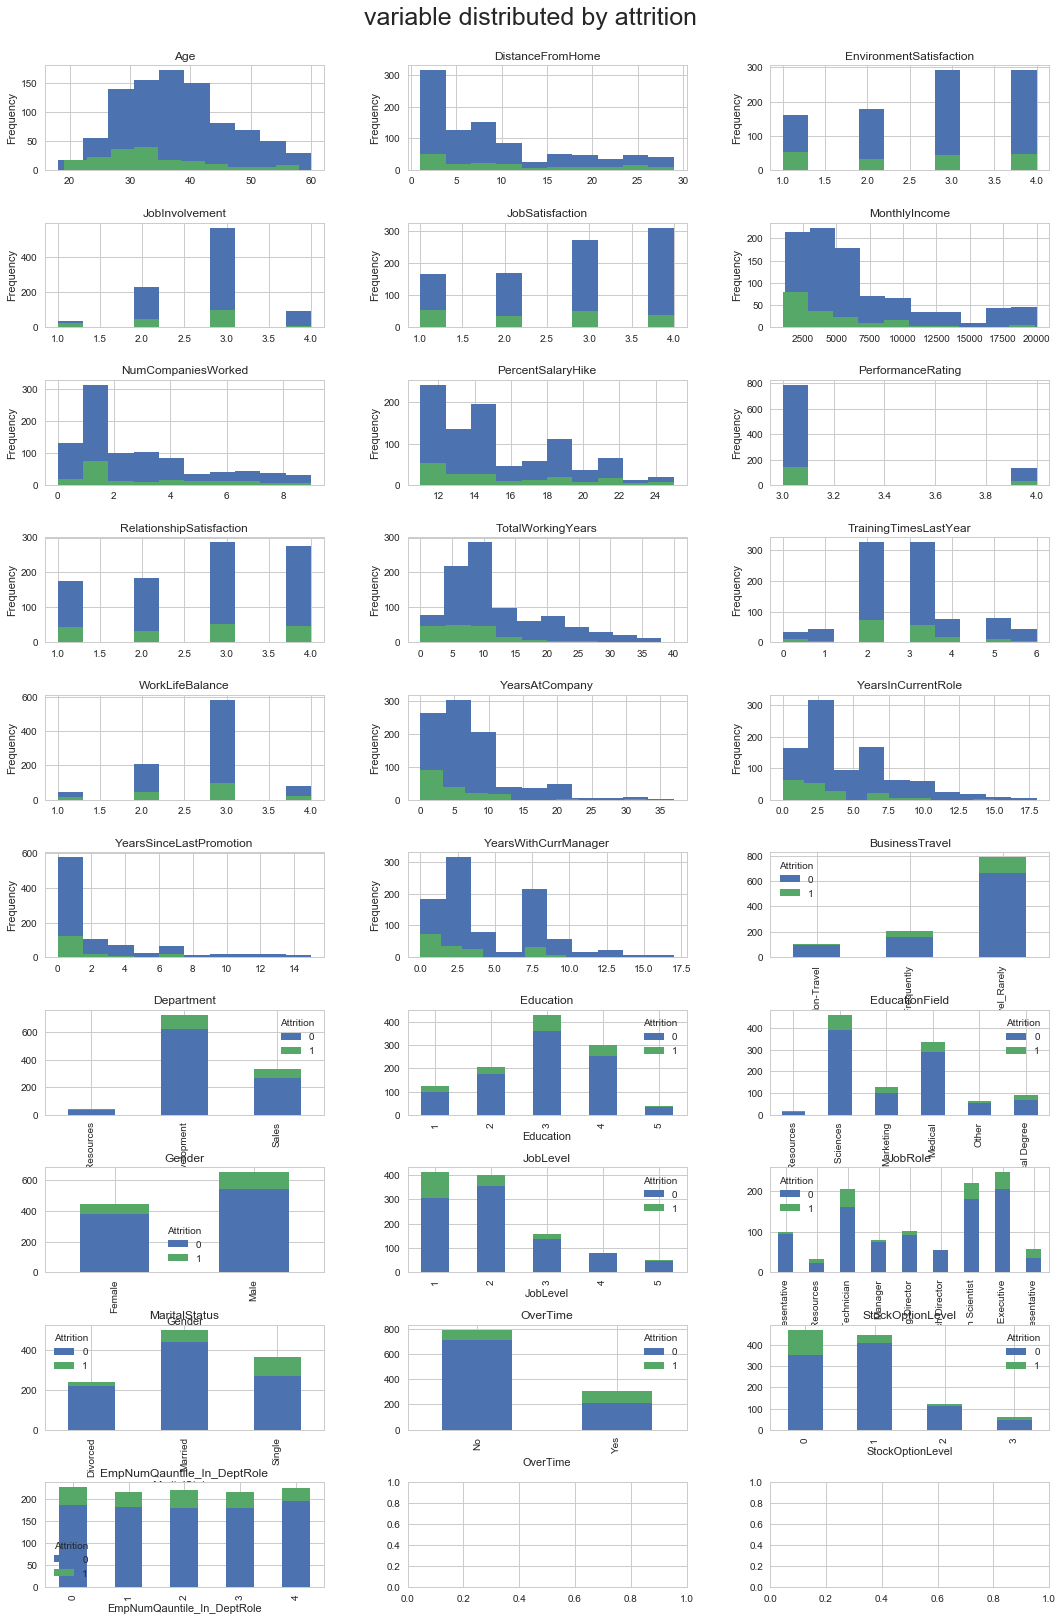

In [16]:
fig, axes = plt.subplots(10, 3, figsize=(18, 28))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
numeric_features= HR_emp_att.dtypes.index[HR_emp_att.dtypes=='int64']
cat_features= HR_emp_att.dtypes.index[(HR_emp_att.dtypes=='category') & (HR_emp_att.dtypes.index!= 'Attrition')]


for i in range(len(numeric_features)):
    i0=int(i/3); i1=i%3;
    
    feature_numeric = numeric_features[i]
    HR_emp_att.groupby('Attrition')[feature_numeric].plot.hist(ax = axes[i0][i1],stacked=True); axes[i0][i1].set_title(feature_numeric)
    
for feature in cat_features:
    i+=1
    if i>=30:
        break
        
    i0=int(i/3); i1=i%3;
    df_grouped = HR_emp_att.groupby([feature,'Attrition'])[feature].count().unstack()
    df_grouped.plot(kind='bar',stacked=True,ax=axes[i0][i1]);axes[i0][i1].set_title(feature)
    
fig.text(0.5,0.9,'variable distributed by attrition',fontsize=25,horizontalalignment='center') 
plt.show()

In [17]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
@interact(y=widgets.Dropdown(
    options=numeric_features.tolist(),
    description='Number:',
    disabled=False,
))
def show_bar(y):
    f, axarr = plt.subplots(1,2,figsize=(16,6))
    sns.violinplot(data=HR_emp_att, palette="Set3", x='Attrition', y=y, ax=axarr[0]);
#     sns.swarmplot(data=HR_emp_att, palette="Set3", x='Attrition', y=y, color="w", alpha=.5, ax=axarr[0]);
    
    sns.boxplot(data=HR_emp_att, palette="Set3", x='Attrition', y=y, ax=axarr[1]);
    sns.despine(left=True, bottom=True)
#     plt.tight_layout()
    plt.show();

## Exploratory analysis

In [18]:
"""more male than female for every job level?
"""
print(__doc__)
df_pivot = HR_emp_att.pivot_table(values='Age',index=['JobRole','Gender'],columns=['JobLevel'],aggfunc='count',fill_value=0)
df_pivot
for col in df_pivot.columns:
    df_pivot[col] = df_pivot.groupby(level=0)[col].transform(lambda g: g.astype(np.float32)/g.sum()*100)
df_pivot.round(2).fillna('')

more male than female for every job level?



JobLevel                              1      2      3      4     5
JobRole                   Gender                                  
Healthcare Representative Female         40.79  37.21   37.5      
                          Male           59.21  62.79   62.5      
Human Resources           Female   30.3  23.08     50             
                          Male     69.7  76.92     50             
Laboratory Technician     Female  34.01  30.91  33.33             
                          Male    65.99  69.09  66.67             
Manager                   Female                58.33  47.83  38.1
                          Male                  41.67  52.17  61.9
Manufacturing Director    Female         46.07  48.84     80      
                          Male           53.93  51.16     20      
Research Director         Female                57.14     40    28
                          Male                  42.86     60    72
Research Scientist        Female  37.07  47.37      0             
                          Male    62.93  52.63    100             
Sales Executive           Female         41.74  34.18     50      
                          Male           58.26  65.82     50      
Sales Representative      Female  46.05  42.86                    
                          Male    53.95  57.14

In [19]:
"""avg salary hike looks like same across dept and level
"""
print(__doc__)
HR_emp_att.groupby(['Department','JobLevel'])['PercentSalaryHike'].mean()

avg salary hike looks like same across dept and level



Department              JobLevel
Human Resources         1           14.666667
                        2           14.769231
                        3           15.666667
                        4           14.500000
                        5           14.571429
Research & Development  1           15.340326
                        2           15.270758
                        3           15.476190
                        4           15.818182
                        5           14.187500
Sales                   1           15.513158
                        2           15.164557
                        3           14.771084
                        4           14.515152
                        5           15.416667
Name: PercentSalaryHike, dtype: float64

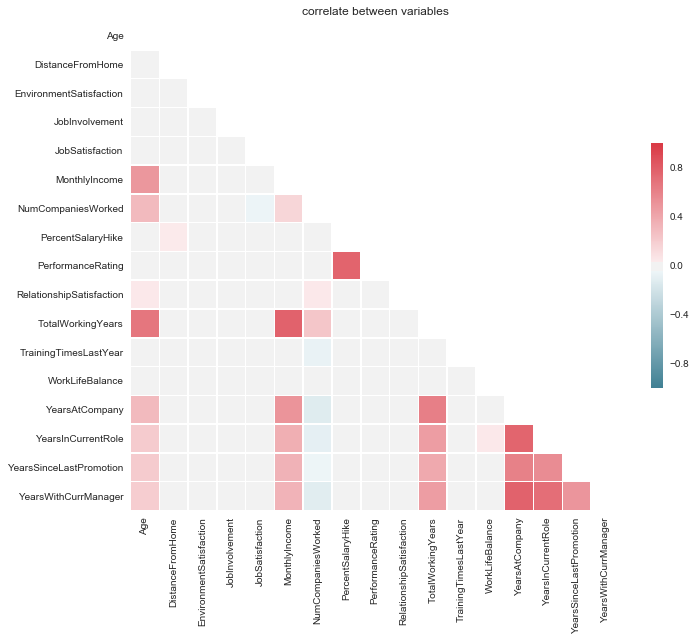

In [20]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

corr = HR_emp_att.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('correlate between variables')
plt.show()

## feature Generation
- Age -> AgeGroup: [young <30,middle <40, adult]
- DistanceFromHome -> HomeDistanceGroup: [nearby <10, faraway]
- Discritize number features

```
HR_transform is new feature dataset

```

In [21]:
from sklearn import cluster
# AgeGroup
HR_emp_att['AgeGroup']= pd.cut(HR_emp_att.Age,[18,25,35,45,65],labels=['young','middle','adult','old'],include_lowest=True)
# KMeans group
HR_emp_att['Satisfaction'] = HR_emp_att.apply(lambda x: (x.EnvironmentSatisfaction+x.JobInvolvement+x.JobSatisfaction+x.RelationshipSatisfaction+x.WorkLifeBalance)/5.0,axis=1)
avg_satisfaction = HR_emp_att['Satisfaction'].mode()
income_avg = HR_emp_att.groupby(['Department','JobLevel','JobRole'])['MonthlyIncome'].mean()

HR_emp_att['IncomeCompareAvg']=[p.MonthlyIncome / income_avg[p.Department,p.JobLevel,p.JobRole] -1 for p in HR_emp_att.itertuples()]

HR_emp_att = HR_emp_att.assign(IncomeRiseEachYear=lambda x: x.MonthlyIncome/(x.TotalWorkingYears+1))
HR_emp_att['Satisfied'] = HR_emp_att['Satisfaction']>=HR_emp_att['Satisfaction'].median()
HR_emp_att['JobSatisfied'] = HR_emp_att['JobSatisfaction']>=HR_emp_att['JobSatisfaction'].median()
HR_emp_att['WorkLifeBalanceSatisfied'] = HR_emp_att['WorkLifeBalance']>=HR_emp_att['WorkLifeBalance'].median()
HR_emp_att['EnvironmentSatisfied'] = HR_emp_att['EnvironmentSatisfaction']>=HR_emp_att['EnvironmentSatisfaction'].median()
HR_emp_att['PerformanceRatingGroup'] = HR_emp_att['PerformanceRating']>=HR_emp_att['PerformanceRating'].median()
HR_emp_att['WorkBeginAge'] = HR_emp_att['Age']-HR_emp_att['TotalWorkingYears']
HR_emp_att['WorkBeginAge'] = HR_emp_att['WorkBeginAge']/HR_emp_att['WorkBeginAge'].median()
HR_emp_att['WorkingYearsPct'] = HR_emp_att['YearsAtCompany']/(HR_emp_att['TotalWorkingYears']+1)

qcut_cols = ['DistanceFromHome','IncomeCompareAvg','TotalWorkingYears', \
             'PercentSalaryHike','YearsInCurrentRole', 'WorkBeginAge',\
             'YearsWithCurrManager','NumCompaniesWorked','YearsAtCompany','IncomeRiseEachYear','WorkingYearsPct']
for col in qcut_cols:
    vals = HR_emp_att[col].values
    
    HR_emp_att[col+'Group'] = pd.qcut(pd.Series(vals),4,duplicates='drop', labels=['bad','soso','good','awesome'])
#     md_km = cluster.KMeans(n_clusters=4)
#     md_km.fit(vals)
#     HR_emp_att[col+'Group'] = pd.Categorical.from_codes(md_km.predict(vals),['bad','soso','good','awesome'])
# remove temp feature
#HR_emp_att.drop(['Satisfaction','LastPromoteCompareAvg','IncomeCompareAvg'],axis=1,inplace=True)
HR_transform = HR_emp_att.drop(qcut_cols \
                + ['Age','EnvironmentSatisfaction','JobSatisfaction','WorkLifeBalance','PerformanceRating','RelationshipSatisfaction','MonthlyIncome'],axis=1)

## find association rules across features

In [22]:
from apyori import apriori
features_cat = HR_transform.select_dtypes(pd.Categorical)
data = []
for i in range(features_cat.shape[0]):
    row = []
    for j in range(features_cat.shape[1]):
        row.append(features_cat.columns[j]+':'+ str(features_cat.iloc[i,j]))
    data.append(row)
results = list(apriori(data,min_support = 0.2, min_lift=2,min_confidence =.8))

results

[RelationRecord(items=frozenset({'JobRole:Sales Executive', 'Department:Sales'}), support=0.22275862068965518, ordered_statistics=[OrderedStatistic(items_base=frozenset({'JobRole:Sales Executive'}), items_add=frozenset({'Department:Sales'}), confidence=1.0, lift=3.2879818594104306)]),
 RelationRecord(items=frozenset({'MaritalStatus:Single', 'StockOptionLevel:0'}), support=0.32, ordered_statistics=[OrderedStatistic(items_base=frozenset({'MaritalStatus:Single'}), items_add=frozenset({'StockOptionLevel:0'}), confidence=1.0, lift=2.327447833065811)]),
 RelationRecord(items=frozenset({'YearsInCurrentRoleGroup:bad', 'YearsAtCompanyGroup:bad'}), support=0.3213793103448276, ordered_statistics=[OrderedStatistic(items_base=frozenset({'YearsAtCompanyGroup:bad'}), items_add=frozenset({'YearsInCurrentRoleGroup:bad'}), confidence=1.0, lift=2.183734939759036)]),
 RelationRecord(items=frozenset({'YearsAtCompanyGroup:bad', 'YearsWithCurrManagerGroup:bad'}), support=0.3213793103448276, ordered_statistic

In [23]:
HR_transform.head()

,Attrition,BusinessTravel,Department,Education,EducationField,Gender,JobInvolvement,JobLevel,JobRole,MaritalStatus,...,IncomeCompareAvgGroup,TotalWorkingYearsGroup,PercentSalaryHikeGroup,YearsInCurrentRoleGroup,WorkBeginAgeGroup,YearsWithCurrManagerGroup,NumCompaniesWorkedGroup,YearsAtCompanyGroup,IncomeRiseEachYearGroup,WorkingYearsPctGroup
0,0,Travel_Rarely,Research & Development,4,Life Sciences,Male,2,2,Manufacturing Director,Divorced,...,good,soso,good,good,good,good,bad,good,awesome,awesome
1,0,Travel_Frequently,Research & Development,4,Life Sciences,Female,3,3,Manufacturing Director,Divorced,...,awesome,awesome,good,good,soso,good,awesome,soso,bad,bad
2,1,Travel_Frequently,Research & Development,3,Life Sciences,Male,1,2,Laboratory Technician,Single,...,awesome,soso,awesome,good,good,good,bad,good,good,awesome
3,0,Travel_Rarely,Research & Development,1,Life Sciences,Female,2,4,Manufacturing Director,Married,...,soso,awesome,good,good,bad,awesome,bad,awesome,good,awesome
4,1,Travel_Frequently,Research & Development,3,Medical,Male,2,1,Laboratory Technician,Divorced,...,soso,bad,good,bad,good,bad,bad,bad,awesome,soso


remove feature that are highly correlated

## Variable Transformations

In [24]:

X_trainset = HR_emp_att.drop(['Attrition'], axis=1).copy()[:train_size]
y_trainset = HR_emp_att.Attrition[:train_size]
X_test = HR_emp_att.drop(['Attrition'], axis=1).copy()[train_size:]
y_test = HR_emp_att.Attrition[train_size:]

from sklearn.feature_extraction import DictVectorizer

def factorize_dataframe(data,cols):
    for col in cols:
        if data[col].dropna().drop_duplicates().shape[0]>2:
            df_dummy = pd.get_dummies(data[col],prefix=col) # factorize return 2 elements array, values and category index
            data = pd.concat([data,df_dummy],axis=1)
            data=data.drop(col,axis=1)
        else:
            data[col] = pd.factorize(data[col])[0]
    return data

cat_vars = X_trainset.dtypes.index[X_trainset.dtypes=='category']
X_trainset = factorize_dataframe(X_trainset, cat_vars)
X_test =  factorize_dataframe(X_test, cat_vars)
X_trainset.columns

Index(['Age', 'DistanceFromHome', 'EnvironmentSatisfaction', 'Gender',
       'JobInvolvement', 'JobSatisfaction', 'MonthlyIncome',
       'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       ...
       'YearsAtCompanyGroup_good', 'YearsAtCompanyGroup_awesome',
       'IncomeRiseEachYearGroup_bad', 'IncomeRiseEachYearGroup_soso',
       'IncomeRiseEachYearGroup_good', 'IncomeRiseEachYearGroup_awesome',
       'WorkingYearsPctGroup_bad', 'WorkingYearsPctGroup_soso',
       'WorkingYearsPctGroup_good', 'WorkingYearsPctGroup_awesome'],
      dtype='object', length=120)

## classification model selection + feature selection
- RandomForecast
- adaboost
- SVM

In [137]:
# select model
from sklearn.model_selection import train_test_split   # cross_validation
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.feature_selection import RFECV,SelectKBest, RFE
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB  
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.mixture import GaussianMixture

from sklearn.metrics import roc_curve,confusion_matrix
from sklearn.metrics import roc_auc_score  
from sklearn.metrics import classification_report 
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.model_selection import StratifiedKFold, cross_val_score


from sklearn.decomposition import PCA
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import  AdaBoostClassifier, GradientBoostingClassifier
from xgboostwrapper import XGBoostClassifier
# resample train dataset
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek
from imblearn import pipeline as pl


X_train, X_val, y_train, y_val = train_test_split(X_trainset,y_trainset ,shuffle=True,test_size=0.2)
# X_train = X_train.reset_index()
# y_train = y_train.reset_index()

smt = SMOTE(random_state=44, kind = 'borderline2')

# parameter_space = {  
#     "clf__n_estimators": [10, 15, 20],  
# #     "clf__criterion": ["gini", "entropy"],  
#     "clf__min_samples_leaf": [2, 4, 6], 
#     "clf__max_depth" : [2,3,4],
#      "clf__min_samples_split" : [5,10,15]
# }  
#  Create a logistic regression estimator 

rfc_model = RandomForestClassifier(warm_start=False, class_weight='balanced',max_features = 'log2',max_depth=4)
lrc_model = LogisticRegression(penalty='l2',C=3,warm_start=True,random_state=17)
xgb_model = XGBoostClassifier(
        weight = [5,1],
        eval_metric = 'auc',
        num_class = 2,
        nthread = 4,
        silent = 1,
        )
adb_model =AdaBoostClassifier(n_estimators=100, learning_rate=.05)
gmx_model = GaussianMixture()


# Use RFECV to pick best features, using Stratified Kfold
rfecv =   RFECV(estimator=lrc_model,step=2, scoring='accuracy',n_jobs=4, verbose=1)
rfe = RFE(rfc_model, n_features_to_select=12)
# This dataset is way too high-dimensional. Better do PCA:
pca = PCA(n_components=2)

# Build estimator from PCA and Univariate selection:

combined_features = FeatureUnion([("pca", pca)]) #,("univ_select", selection),

mdsel_out = {}
for md in [ lrc_model,xgb_model  ]: #adb_model, gmx_model,rfc_model,
    md_name = str(md.__class__).split('.')[-1][:-2]
    print(md)
    pipe = pl.Pipeline([('scale',StandardScaler()),('rfe',rfe),('clf',md)])
    scores = cross_val_score(pipe, X_trainset, y_trainset,scoring= 'accuracy', n_jobs=4, cv =3)
    
    mdsel_out[md_name]= [np.mean(scores), np.std(scores)]
pd.DataFrame(mdsel_out, index=['mean','std'])

LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=True)


,LogisticRegression,XGBoostClassifier
mean,0.865447,0.853628
std,0.009387,0.009402


In [126]:


# Define a range of hyper parameters for grid search
C_range = list(np.linspace(.5,1,5))

# xgb_parameters = {
#         'clf__num_boost_round': [100, 250, 500],
#         'clf__eta': [0.05, 0.1, 0.3],
#         'clf__max_depth': [6, 9, 12],
#         'clf__subsample': [0.9, 1.0],
#         'clf__colsample_bytree': [0.9, 1.0],
#     }    

parameter_space = dict( #features__rfecv__estimator__penalty = penalty_options,
                #    features__rfecv__estimator__C=[1,0.5,0.1],
                  #features__pca__n_components=[2],
                  #features__univ_select__k=[1,2,5,10],
#                   clf__learning_rate=(1, 0.1, 0.01),
#                     clf__C=(10,1, 0.1),
#                   clf__solver = ['newton-cg', 'linear', 'saga' ],
#                   clf__max_iter = [100, 200, 500],
#                     clf__max_features = ['sqrt','log2'],
#                     clf__min_samples_split = [3,5],
#                     resample__kind = ['regular', 'borderline1', 'borderline2'],
#                     clf__random_state = np.random.randint(1,100,3)
                        rfe__n_features_to_select=[5,8,11,16]
                    )
# parameter_space.update(xgb_parameters)
                  
pipe = pl.Pipeline([('scale',StandardScaler()),('rfe',rfe),('clf',lrc_model)])
grid_search = GridSearchCV(pipe , parameter_space,cv= StratifiedKFold(n_splits=3), n_jobs=4,verbose=1,scoring='f1')
grid_search.fit(X_trainset,y_trainset)
print("Best score: %0.3f" % grid_search.best_score_)

print('best param:', grid_search.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:    8.2s finished


Best score: 0.435
best param: {'rfe__n_features_to_select': 16}


In [127]:
y_hat = grid_search.predict(X_val)
print('random forecast - f1:%f'% f1_score(y_val, y_hat))
# X_train.columns[(rfc_model.feature_importances_>.01).ravel()]
print(classification_report(y_val, y_hat))

random forecast - f1:0.431373
             precision    recall  f1-score   support

          0       0.89      0.97      0.93       186
          1       0.65      0.32      0.43        34

avg / total       0.85      0.87      0.85       220



Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rfe', RFE(estimator=LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=17, solver='libl...nalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=True))])


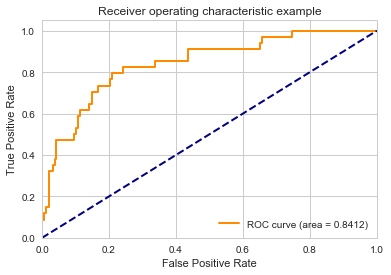

array([[180,   6],
       [ 23,  11]], dtype=int64)

In [134]:
bclf = grid_search.best_estimator_  
print(bclf)
y_pred = bclf.predict(X_val)
y_pred_pro = bclf.predict_proba(X_val)  
y_scores = pd.DataFrame(y_pred_pro)[1].values  
auc_value = roc_auc_score(y_val, y_scores)  
#绘制ROC曲线  
fpr, tpr, thresholds = roc_curve(y_val, y_scores, pos_label=1.0)  
plt.figure()  
lw = 2  
plt.plot(fpr, tpr, color='darkorange', linewidth=lw, label='ROC curve (area = %0.4f)' % auc_value)  
plt.plot([0, 1], [0, 1], color='navy', linewidth=lw, linestyle='--')  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.05])  
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')  
plt.title('Receiver operating characteristic example')  
plt.legend(loc="lower right")  
plt.show()
confusion_matrix(y_val, y_pred)



In [135]:

y_pred = bclf.predict(X_test)
import itertools as it
print(list(it.groupby([0,1], lambda x: np.sum(y_pred==x))))

y_pred = y_pred.reshape([-1,1])

np.savetxt('data/test_result.csv',y_pred,fmt='%s',header='result')

[(315, <itertools._grouper object at 0x0000000011449400>), (35, <itertools._grouper object at 0x0000000011449080>)]


## fit model using auto_ml

In [147]:
from auto_ml import Predictor
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

X_trainset = HR_transform.drop(['Attrition'], axis=1).copy()[:train_size]
y_trainset = HR_transform.Attrition[:train_size]
for cat in cat_vars:
    X_trainset[cat] = X_trainset[cat].astype(str)

# X_resampled, y_resampled =smt.fit_sample(X_trainset, y_trainset)
df_resampled = pd.DataFrame(X_trainset,columns=X_trainset.columns)
df_resampled['Attrition'] = y_trainset

HR_auto = df_resampled.copy()


df_train, df_test = train_test_split(HR_auto,shuffle=True,test_size=0.2)

column_descriptions = {'Attrition':'output'}
column_descriptions.update(dict(zip(cat_features,['categorical']*cat_features.shape[0])))

ml_predictor = Predictor(type_of_estimator='classifier', column_descriptions=column_descriptions)

# ml_predictor.train_categorical_ensemble(df_train,categorical_column='Department', model_names = ['XGBClassifier'], perform_feature_selection= True)
ml_predictor.train(df_train, model_names = ['XGBClassifier'], perform_feature_selection= True, perform_feature_scaling=True)
test_result = ml_predictor.predict(df_test)
accuracy_score(test_result, df_test['Attrition'])

Welcome to auto_ml! We're about to go through and make sense of your data using machine learning, and give you a production-ready pipeline to get predictions with.

If you have any issues, or new feature ideas, let us know at http://auto.ml
You are running on version 2.9.10
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{}
Running basic data cleaning
could not convert string to float: 'young'
could not convert string to float: 'adult'
could not convert string to float: 'adult'
could not convert string to float: 'middle'
could not convert string to float: 'middle'
could not convert string to float: 'adult'
could not convert string to float: 'adult'
could not convert string to float: 'young'
could not convert string to float: 'adult'
could not convert string to float: 'old'


Encountered a column that is not marked as categorical, but is an "object" pandas typ

Performing feature selection
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{}


********************************************************************************************
About to fit the pipeline for the model XGBClassifier to predict Attrition
Started at:
2018-04-03 23:27:47
Finished training the pipeline!
Total training time:
0:00:01


Here are the results from our XGBClassifier
predicting Attrition
Calculating feature responses, for advanced analytics.
The printed list will only contain at most the top 100 features.
+----+-----------------------------------+--------------+----------+-------------------+-------------------+-----------+-----------+-----------+-----------+
|    | Feature Name                      |   Importance |    Delta |   FR_Decrementing |   FR_Incrementing |   FRD_abs |   FRI_abs |   FRD_MAD |   FRI_MAD |
|----+---------------------

0.8545454545454545

In [148]:
y_hat = ml_predictor.predict(X_val)
print(classification_report(y_val, y_hat))

             precision    recall  f1-score   support

          0       0.85      0.87      0.86       180
          1       0.36      0.33      0.34        40

avg / total       0.76      0.77      0.77       220



In [149]:

y_pred = np.array(ml_predictor.predict(X_test))
import itertools as it
print(list(it.groupby([0,1], lambda x: np.sum(y_pred==x))))


np.savetxt('data/test_result_automl.csv',y_pred,fmt='%s',header='result');

[(306, <itertools._grouper object at 0x00000000127F1E48>), (44, <itertools._grouper object at 0x00000000112F8198>)]
